# Imports

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import random

## Image Directory

In [2]:
directory= "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

In [3]:
label = []
path = []
for dir_name, _, filenames in os.walk(directory):
    for filename in filenames:
        if dir_name.split()[-1] != 'GT':
            if os.path.splitext(filename)[-1] == '.png':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

df = pd.DataFrame(columns=['path', 'label'])
df['path'] = path
df['label'] = label

## Dataset Samples

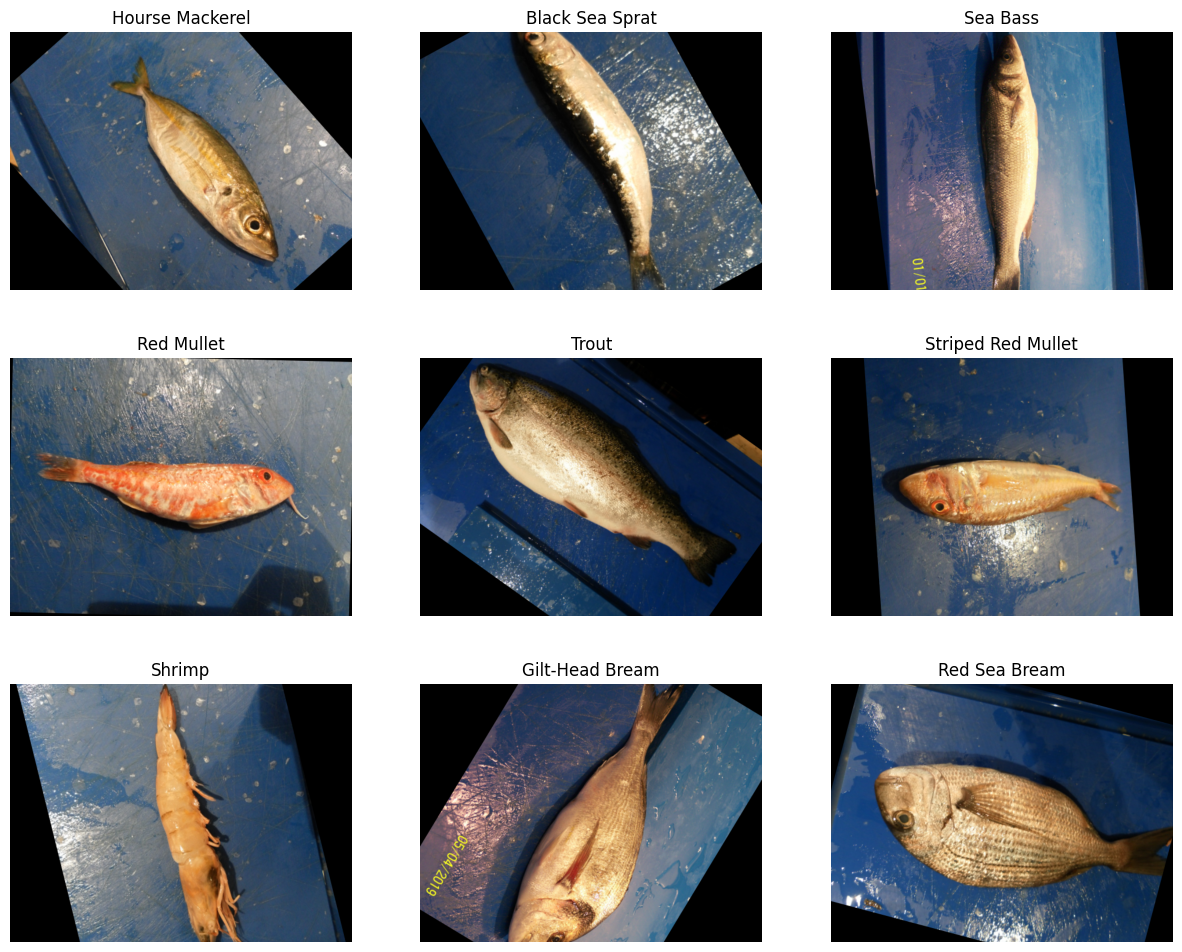

In [48]:
i = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    i+=1

## Train-Validation-Test Split

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=21)

In [6]:
# Görüntü ve etiketleri yükleme ve preprocessing fonksiyonu
def process_path(file_path, label):
    # Görüntüyü yükleme
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [590, 445])
    img = img / 255.0  # Normalizasyon

    # Label one hot encoder
    label = tf.one_hot(label, depth=len(label_encoder.classes_))
    return img, label

## Label Encoding

In [7]:
# label encoding
label_encoder = LabelEncoder()
train['label'] = label_encoder.fit_transform(train['label'])
val['label'] = label_encoder.transform(val['label'])
test['label'] = label_encoder.transform(test['label'])

## Tensorflow Dataset Oluşturma

Hızlı bir train süreci için verilerin tensorflow dataset formatına çevrilmesi önem arz etmektedir.

In [8]:
# TensorFlow Dataset oluşturma
def dataframe_to_dataset(df):
    paths = df['path'].values
    labels = df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    return dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)

# Veri setlerini konfigüre etme
train_ds = train_ds.shuffle(buffer_size=1000).batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model
Bu modelde base bir convolution layer kullanılarak yüksek accuracy'e ulaşılıp ulaşılamyacağı değerlendirilmek istenmiştir.
Pre-trained model yapıları veya daha fazla hidden layer ekleme seçenekleri değerlendirilebilir.

In [9]:
# modeli oluşturma
model = Sequential([
    Input(shape=(590, 445, 3)),
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [47]:
# modeli derleme
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', 'F1Score', "AUC"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True)]

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 588, 443, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 588, 443, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 294, 221, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1039584)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1039584)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │     9,356,265 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,356,777 (35.69 MB)

 Trainable params: 9,356,745 (35.69 MB)

 Non-trainable params: 32 (128.00 B)

## Train

In [12]:
history = model.fit(
    train_ds,
    epochs=7,
    callbacks=callbacks,
    validation_data=val_ds,
    batch_size = 16
)

Epoch 1/7


I0000 00:00:1729793983.618498      98 service.cc:145] XLA service 0x795e08008100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729793983.618561      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729793983.618567      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/90 ━━━━━━━━━━━━━━━━━━━━ 25:19 17s/step - AUC: 0.5525 - F1Score: 0.0984 - accuracy: 0.0938 - loss: 2.8307

I0000 00:00:1729793993.048637      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - AUC: 0.7684 - F1Score: 0.5495 - accuracy: 0.5514 - loss: 40.8142
Epoch 1: val_loss improved from inf to 4.78549, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 485ms/step - AUC: 0.7695 - F1Score: 0.5516 - accuracy: 0.5534 - loss: 40.5482 - val_AUC: 0.7554 - val_F1Score: 0.4060 - val_accuracy: 0.4340 - val_loss: 4.7855
Epoch 2/7
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - AUC: 0.9830 - F1Score: 0.9557 - accuracy: 0.9556 - loss: 0.5494
Epoch 2: val_loss improved from 4.78549 to 2.27417, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - AUC: 0.9830 - F1Score: 0.9557 - accuracy: 0.9557 - loss: 0.5487 - val_AUC: 0.8762 - val_F1Score: 0.6238 - val_accuracy: 0.6208 - val_loss: 2.2742
Epoch 3/7
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - AUC: 0.9932 - F1Score: 0.9802 - accuracy: 0.9803 - loss: 0.2411
Epoch 3: val_loss improved from 2.27417 to 2.03921, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━

Bu model yapısı ve epoch sayısı daha önceki denemelerde elde edilen sonuçlara istinaden bu şekilde oluşturulmuştur. Modelin fit edilmesi sonucunda training accuracy: %99 validation accuracy: %92.57 olmuştur. Model checkpoint kullanılması nedeniyle çok yüksek training accuracy elde edilmesine rağmen validation accuracy'nin yüksekliği modelin genelleme yeteneğinin yüksek olduğunu göstermektedir.

## Visualizing Training Process

In [13]:
# Model sürecinin görselleştirilmesi
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

  # Loss görselleştirme
  plt.figure(figsize=(10,5))
  plt.plot(history.history[train_loss], label='Training Loss')
  plt.plot(history.history[val_loss], label='Validation Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Metrikleri görselleştirme
  plt.figure(figsize=(10,5))
  plt.plot(history.history[train_metric], label=f"Training:{train_metric}")
  plt.plot(history.history[val_metric], label=f"Validation:{val_metric}")
  plt.title(f'Training and Validation {train_metric} Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel(f'train_metric')
  plt.legend()
  plt.show()

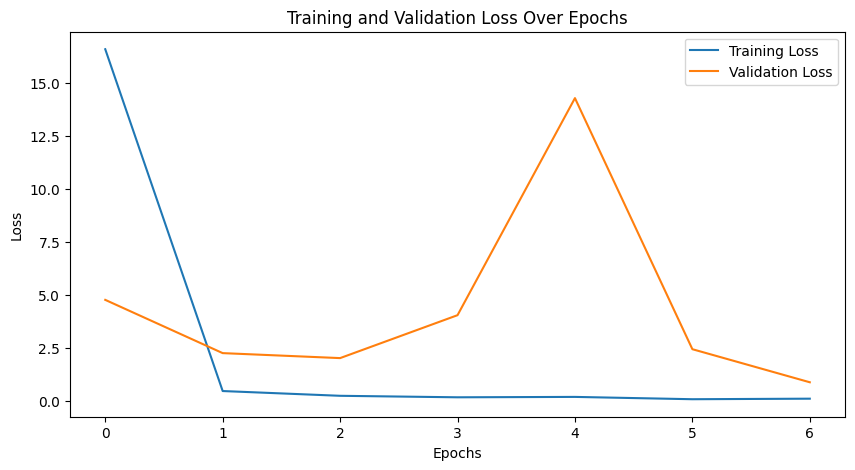

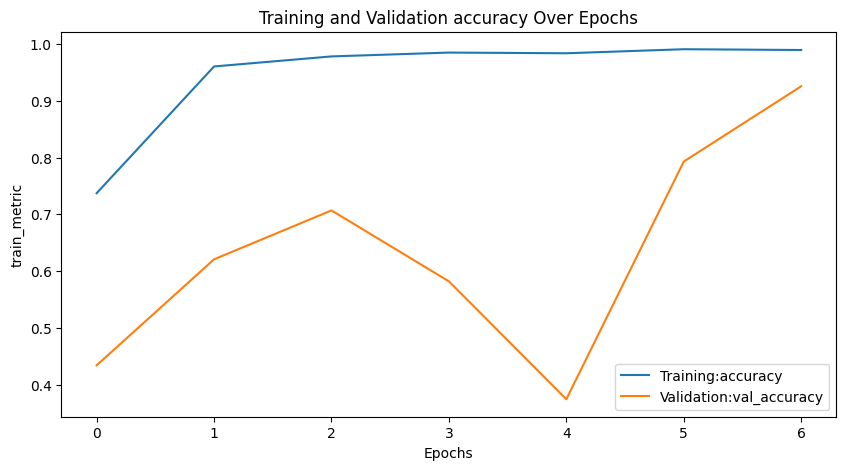

In [14]:
plot_training_history(history)

# Getting Best Epoch Details and Best Parameters

In [15]:
def get_best_epoch_details(history):
  val_losses = history.history['val_loss']
  min_val_loss_index = val_losses.index(min(val_losses))
  best_epoch = min_val_loss_index + 1

  epoch_details = {}
  for key in history.history.keys():
    epoch_details[key] = history.history[key][min_val_loss_index]

  epoch_details['best_epoch'] = best_epoch
  return epoch_details

In [16]:
best_epoch_details = get_best_epoch_details(history)
print(f"Best epoch details: {best_epoch_details}")

Best epoch details: {'AUC': 0.9961913824081421, 'F1Score': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.9904153 , 0.9888179 , 0.9946112 , 0.9914396 , 0.9858933 ,
       0.9884704 , 0.99368083, 0.9866875 , 0.98628044], dtype=float32)>, 'accuracy': 0.9895833134651184, 'loss': 0.12589174509048462, 'val_AUC': 0.9721466898918152, 'val_F1Score': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.93567246, 0.9627507 , 0.9526813 , 0.97023803, 0.90540534,
       0.8494983 , 0.9904762 , 0.8587257 , 0.89811313], dtype=float32)>, 'val_accuracy': 0.925694465637207, 'val_loss': 0.8994405269622803, 'best_epoch': 7}


In [17]:
saved_model = tf.keras.models.load_model('best_model.keras')
saved_model

<Sequential name=sequential, built=True>

# Evaluation

In [19]:
score = saved_model.evaluate(test_ds,batch_size=256)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - AUC: 0.9772 - F1Score: 0.9226 - accuracy: 0.9258 - loss: 0.6632
Accuracy: 92.00%
Loss:  0.7834576368331909


Fit etme sonucunda elde edilen yüksek accuracy değerlerden yola çıkarak overfit olma ihtimaline rağmen bağımsız test dataset'i ile modeli evaluate ettiğimizde tutarlı bir sonuç elde edildiği görülmektedir. Model genel anlamda yüksek doğruluk ile balıkları sınıflandırabilmektedir.

## Predictions

In [60]:
# Tahminler
pred = saved_model.predict(test_ds)
pred_classes = np.argmax(pred, axis=1)

# True class labels
true_classes = []
for _, label in test_ds:
    true_classes.extend(np.argmax(label.numpy(), axis=1))  # Çok sınıflı durumda, argmax ile alıyoruz

true_classes = np.array(true_classes)  # Listeyi numpy dizisine çevir

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step


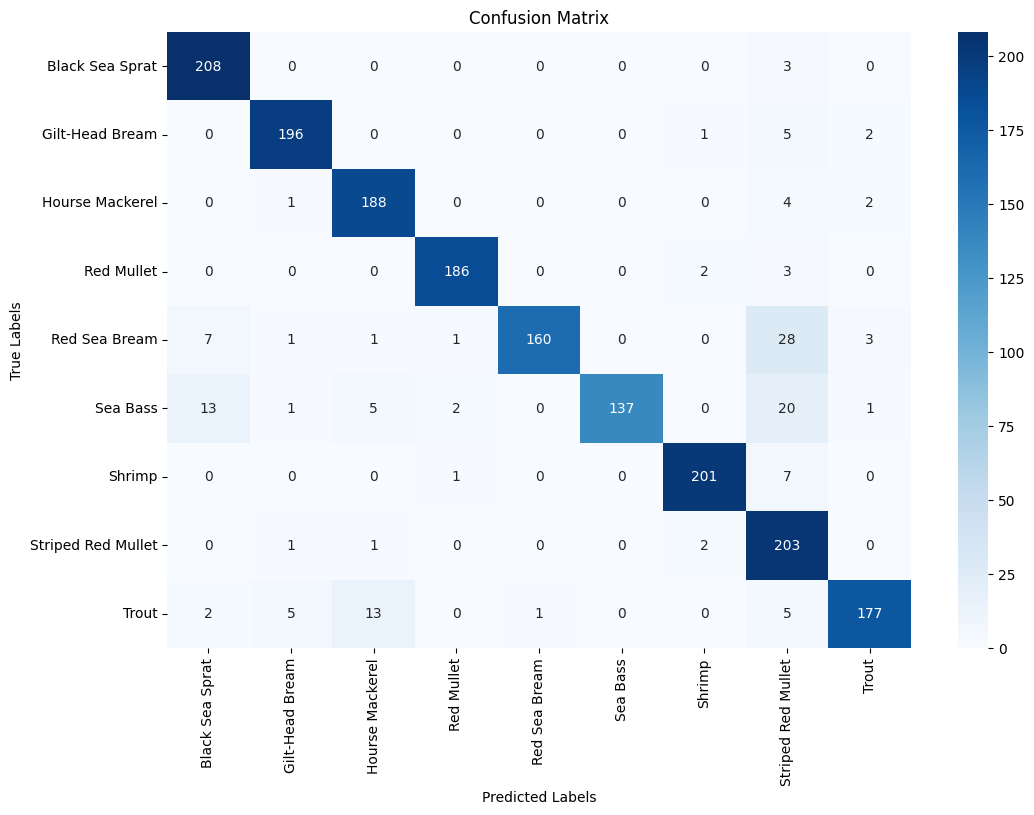

In [61]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, pred_classes)

class_labels = label_encoder.classes_ 

# Confusion matrix görselleştirme
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Classification Report

In [62]:
report_dict = classification_report(true_classes, pred_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

                    precision    recall  f1-score  support
Black Sea Sprat      0.904348  0.985782  0.943311   211.00
Gilt-Head Bream      0.956098  0.960784  0.958435   204.00
Hourse Mackerel      0.903846  0.964103  0.933002   195.00
Red Mullet           0.978947  0.973822  0.976378   191.00
Red Sea Bream        0.993789  0.796020  0.883978   201.00
Sea Bass             1.000000  0.765363  0.867089   179.00
Shrimp               0.975728  0.961722  0.968675   209.00
Striped Red Mullet   0.730216  0.980676  0.837113   207.00
Trout                0.956757  0.871921  0.912371   203.00
accuracy             0.920000  0.920000  0.920000     0.92
macro avg            0.933303  0.917799  0.920039  1800.00
weighted avg         0.931747  0.920000  0.920455  1800.00


## Visualizing Predictions

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step


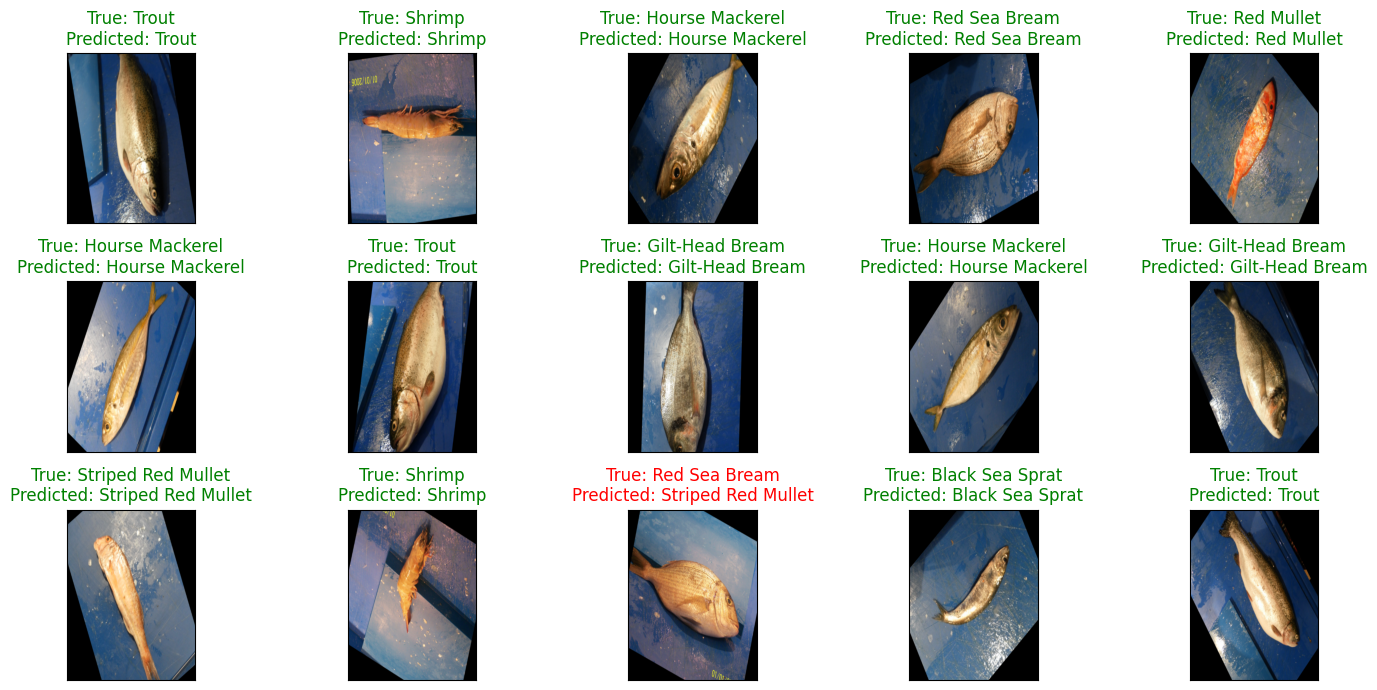

In [76]:
images = []
labels = []

# Yeterli örnek almak için test_ds'yi unbatch edin ve listeye ekleyin
for image, label in test_ds.unbatch().take(1000):
    images.append(image.numpy())
    labels.append(np.argmax(label.numpy()))  # one-hot encoded ise argmax ile sınıf indeksini alın

images = np.array(images)
labels = np.array(labels)

# Tahminleri alın
pred = model.predict(test_ds)
pred_classes = np.argmax(pred, axis=1)  # Her tahminin en yüksek olasılıklı sınıfını alın

# Rastgele 15 örnek seçin
indices = random.sample(range(len(images)), 15)
random_images = images[indices]
random_labels = labels[indices]
random_preds = pred_classes[indices]

# Görselleştirme
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(random_images[i])
    if random_labels[i] == random_preds[i]:
        color = 'green'
    else:
        color = 'red'
    ax.set_title(f"True: {class_labels[random_labels[i]]}\nPredicted: {class_labels[random_preds[i]]}", color=color)

plt.tight_layout()
plt.show()

# Conclusion
Rastgele seçilen 15 test örneği üzerinde elde edilen sonuçlara bakıldığında modelin yüksek doğruluk oranıyla tahminleme yapabildiği görülmektedir. 
Farklı yöntemler denenerek (cnn mimarisi yerine ann mimarisi kullanmak gibi) model daha başarılı hale getirilebilir.